In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from rfpimp import feature_corr_matrix
from sklearn.model_selection import (
    cross_val_score,
    RepeatedKFold,
    GridSearchCV,RandomizedSearchCV
)
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


In [3]:
# plot functions

def df_datatypes(dataframe):
    print(dataframe.columns.to_series().groupby(dataframe.dtypes).groups)
    
def missing(dataframe, graph=False):
    dataframe_na = (dataframe.isnull().sum() / len(dataframe)) * 100
    dataframe_na = dataframe_na.drop(dataframe_na[dataframe_na == 0].index).sort_values(
        ascending=False
    )[:30]
    missing_data = pd.DataFrame({"Missing Ratio": dataframe_na})
    print(missing_data.head(20))
    if graph == True:
        missing_data = dataframe.columns[dataframe.isnull().any()].tolist()
        msno.matrix(dataframe[missing_data])
        msno.heatmap(dataframe[missing_data], figsize=(20, 20))

def cardinality(dataframe, datatype):
    d = []
    columns = dataframe.dtypes[dataframe.dtypes == datatype].index
    # columns = dataframe.columns.tolist()
    for c in columns:
        data = dataframe[c].nunique()
        d.append({"Column": c, "UniqueValue": data})
    df = pd.DataFrame(d).sort_values(ascending=False, by="UniqueValue")
    print(df)

def define_vars(dataframe, card_thresh):
    dtypes = dataframe.dtypes
    cat_feats = dataframe.dtypes[dataframe.dtypes == "object"].index
    numeric_feats = dataframe.dtypes[dataframe.dtypes != "object"].index
    col_nunique = dict()
    for col in numeric_feats:
        col_nunique[col] = dataframe[col].nunique()
    col_nunique = pd.Series(col_nunique)
    cols_discrete = col_nunique[col_nunique < card_thresh].index.tolist()
    cols_continuous = col_nunique[col_nunique >= card_thresh].index.tolist()
    return cols_discrete, cols_continuous, cat_feats

def PlotCont(dataframe, columns):
    fcols = 2
    frows = len(columns)
    plt.figure(figsize=(3 * fcols, 4 * frows))
    i = 0
    for col in columns:
        i += 1
        ax = plt.subplot(frows, fcols, i)
        sns.distplot(dataframe[col], ax=ax)
    plt.xlabel(col)
    
def PlotCat(dataframe, cat_feats, fcols=3):
    fcols = fcols
    frows = ceil(len(cat_feats) / fcols)
    plt.figure(figsize=(20, frows * 4))

    for i, col in enumerate(cat_feats):
        plt.subplot(frows, fcols, i + 1)
        sns.countplot(dataframe[col])
        


def PlotCatRegress(dataframe,target,cat_feats,fcols=3):
    fcols = 3
    frows = ceil(len(cat_feats)/fcols)
    plt.figure(figsize = (20,frows*4))
    
    for i,col in enumerate(cat_feats):
        plt.subplot(frows,fcols,i+1)
        sns.violinplot(dataframe[col],dataframe[target],inner="stick")

# plots all continuous variables vs target


def PlotContRegress(dataframe,target,columns):
    fcols = 2
    frows = len(columns)
    plt.figure(figsize=(3*fcols,4*frows))
    i=0
    for col in columns:
        i+=1
        ax=plt.subplot(frows,fcols,i)
        sns.regplot(x=col,y=target,data=dataframe,ax=ax)
    plt.xlabel(col)

def pear_corr(dataframe):
    df_corr_mat = feature_corr_matrix(dataframe)
    df_corr_mat = df_corr_mat.dropna(axis='columns',how='all')
    df_corr_mat = df_corr_mat.dropna()
    df_corr_mat = df_corr_mat.values
    corr_condensed = hc.distance.squareform(1-df_corr_mat)
    z = hc.linkage(corr_condensed,method='average')
    fig = plt.figure(figsize=(20,10))
    dendrogram = hc.dendrogram(z,labels=dataframe.columns,orientation = 'left',leaf_font_size = 8)
        

In [4]:
# read data and look at datatypes

boston_input = pd.read_csv('C:\\Users\\jstnj\\Google Drive\\Northwestern\\MachineLearning\\Joyce_Week3_422\\boston.csv')

df_datatypes(boston_input)
print(boston_input.head(5))



{dtype('int64'): Index(['chas', 'rad', 'tax'], dtype='object'), dtype('float64'): Index(['crim', 'zn', 'indus', 'nox', 'rooms', 'age', 'dis', 'ptratio', 'lstat',
       'mv'],
      dtype='object'), dtype('O'): Index(['neighborhood'], dtype='object')}
  neighborhood     crim    zn  indus  chas    nox  rooms   age     dis  rad  \
0       Nahant  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1   
1   Swampscott  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2   
2   Swanpscott  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2   
3   Marblehead  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3   
4   Marblehead  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3   

   tax  ptratio  lstat    mv  
0  296     15.3   4.98  24.0  
1  242     17.8   9.14  21.6  
2  242     17.8   4.03  34.7  
3  222     18.7   2.94  33.4  
4  222     18.7   5.33  36.2  


In [5]:
# see if any missing data, none
missing(boston_input)

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [6]:
# check cardinality of int

print(cardinality(boston_input,datatype= 'int64'))
print(cardinality(boston_input,datatype= 'float64'))
print(cardinality(boston_input,datatype= 'object'))

# no discrete variables for numerical variables, will just define continuous and cat

discrete,cont,cat = define_vars(boston_input,1) # no discrete 1
print(discrete)
print(cont)
print(cat)

  Column  UniqueValue
2    tax           66
1    rad            9
0   chas            2
None
    Column  UniqueValue
0     crim          504
8    lstat          455
4    rooms          446
6      dis          412
5      age          356
9       mv          228
3      nox           81
2    indus           76
7  ptratio           46
1       zn           26
None
         Column  UniqueValue
0  neighborhood           93
None
[]
['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'mv']
Index(['neighborhood'], dtype='object')


Cambridge           30
Savin_Hill          23
Lynn                22
Roxbury             19
Newton              18
Somerville          15
South_Boston        13
Quincy              12
Brookline           12
Medford             11
East_Boston         11
Dorchester          11
Waltham             11
Framingham          10
Peabody              9
Malden               9
Allston-Brighton     8
Weymouth             8
Braintree            8
Downtown             8
Belmont              8
Revere               8
Charlestown          7
Salem                7
Everett              7
Arlington            7
Forest_Hills         7
Woburn               6
Mattapan             6
Beverly              6
                    ..
Scituate             2
Holbrook             2
Ashland              2
Sudbury              2
North_End            2
Bedford              2
North_Reading        2
Marshfield           2
Rockland             2
Hingham              2
Weston               2
Middleton            1
Topsfield  

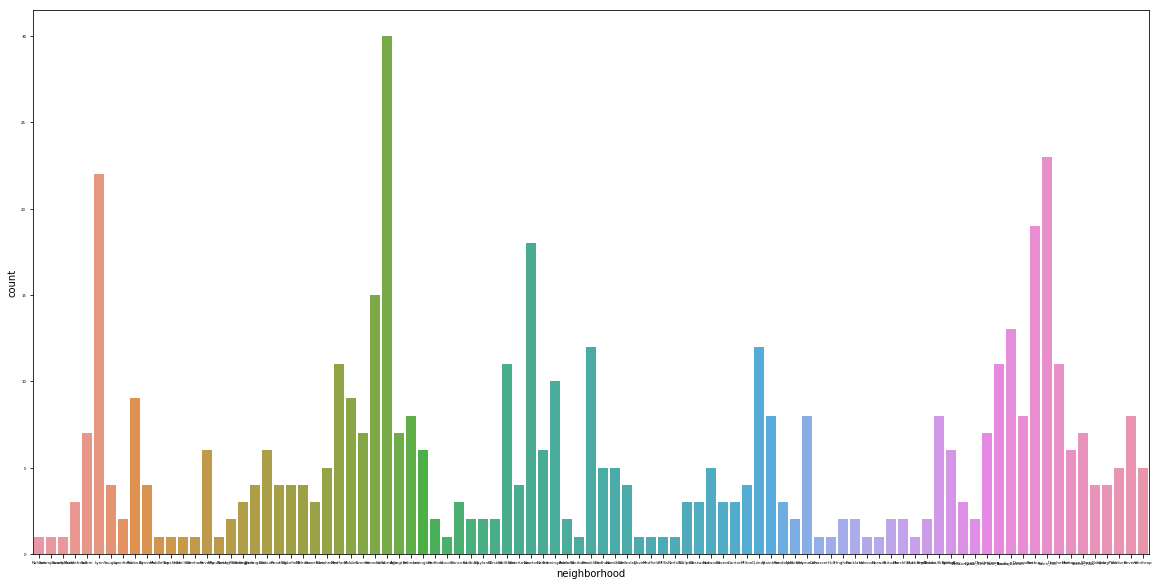

In [7]:
# do EDA on cat variables
plt.figure(figsize=(20,10))
plt.tick_params(labelsize=4)
sns.countplot(boston_input.neighborhood)


# neighborhood - name of the boston neighborhood

# look at count

boston_input.neighborhood.value_counts()

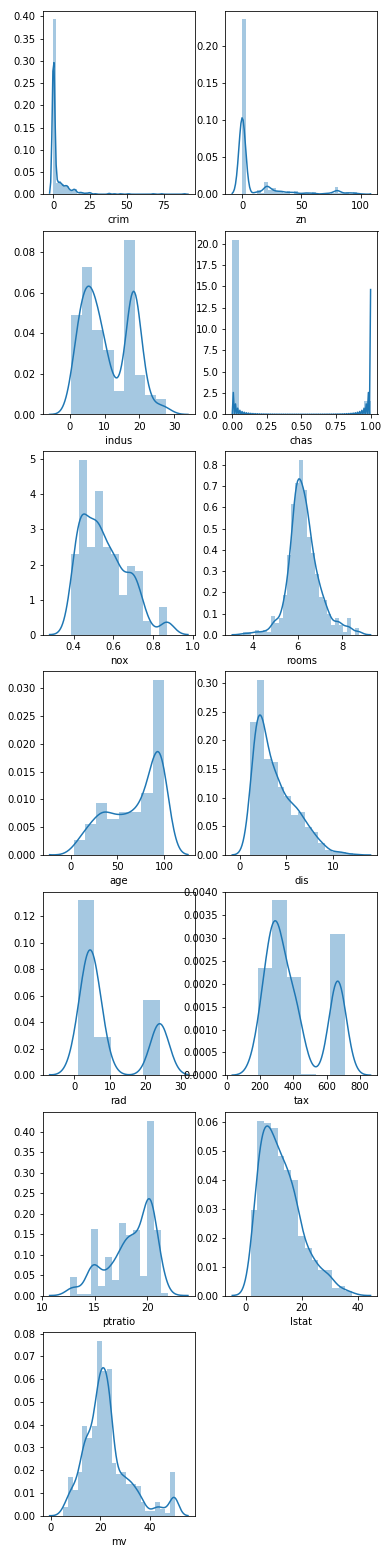

In [8]:
PlotCont(boston_input,cont)

# do eda on numeric variables, mostly continuous 

# mv - median values of homes (target)

# crim - crime rate
# zn (percent of zone land for lots)
# indus - percent of business that is industrial
# chas on charles river or not
# nox - air pollution conecntration
# rooms, average number of rooms
# age - percentage of homes before 1940
# dis - weighted distance to employment center
# rad - accessibility to radial highways
# tax - tax rate
# ptratio - pupil/teacher ratio
# lstat - percentage of population of low status


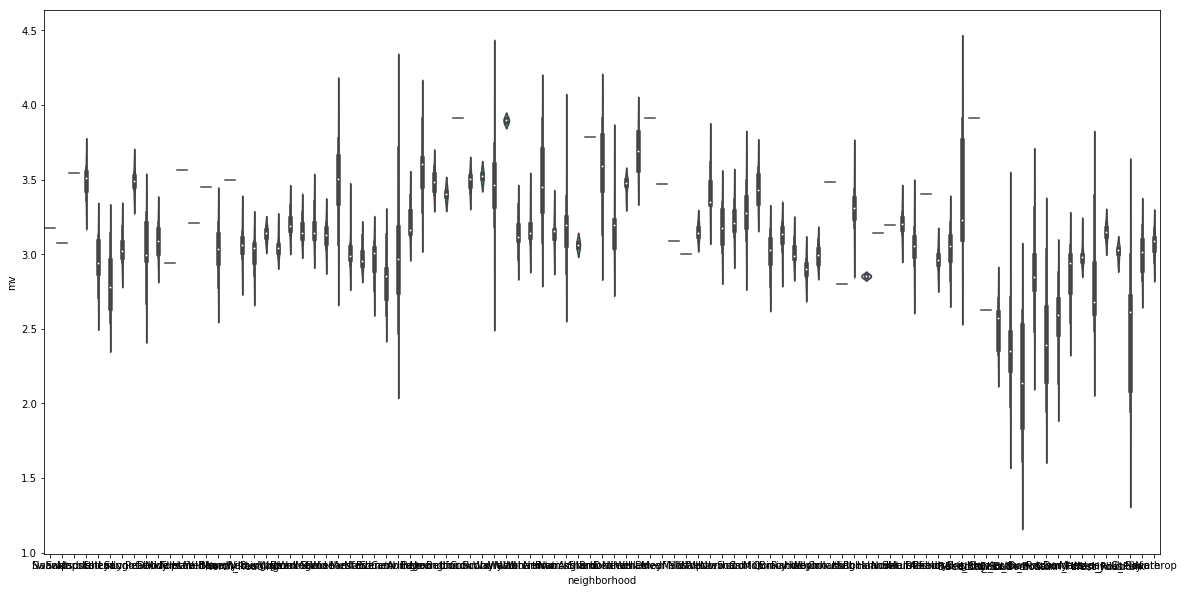

In [9]:
# look at values 
plt.figure(figsize=(20,10))
sns.violinplot(x=boston_input.neighborhood,y=np.log(boston_input.mv))

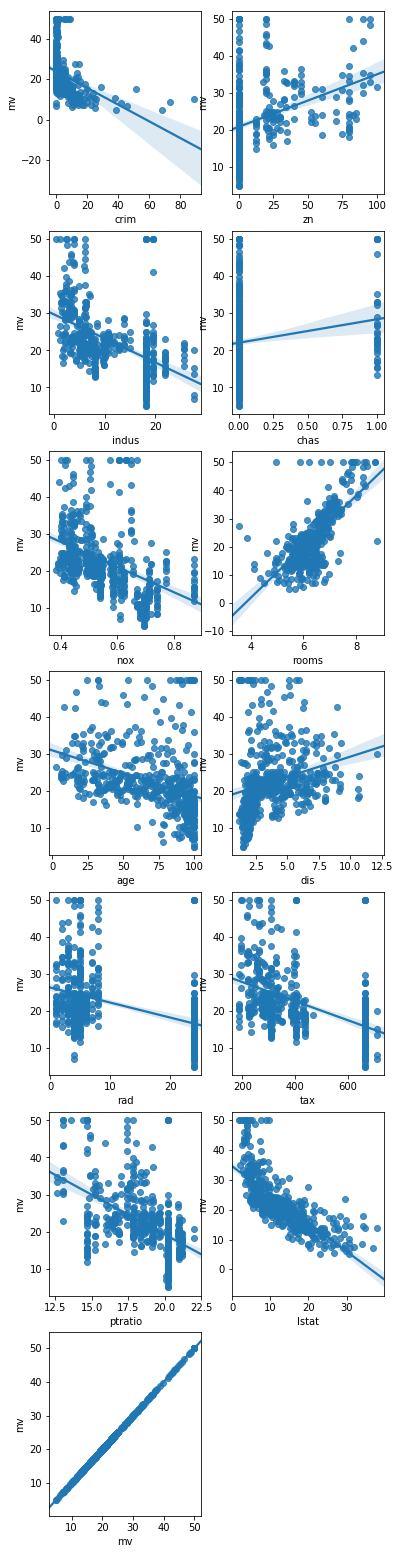

In [10]:
PlotContRegress(boston_input,'mv',cont)

# crim - crime rate
# zn (percent of zone land for lots)
# indus - percent of business that is industrial
# chas on charles river or not
# nox - air pollution conecntration
# rooms, average number of rooms
# age - percentage of homes before 1940
# dis - weighted distance to employment center
# rad - accessibility to radial highways
# tax - tax rate
# ptratio - pupil/teacher ratio
# lstat - percentage of population of low status


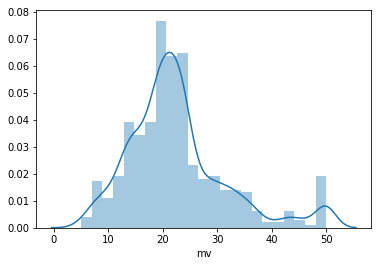

In [11]:
sns.distplot(boston_input.mv)

In [12]:
# transform the y variable using log

X = boston_input.drop(['mv','neighborhood'],axis=1)
y = np.log(boston_input.mv)

print(X.head(5))

      crim    zn  indus  chas    nox  rooms   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

   lstat  
0   4.98  
1   9.14  
2   4.03  
3   2.94  
4   5.33  


C:\Users\jstnj\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


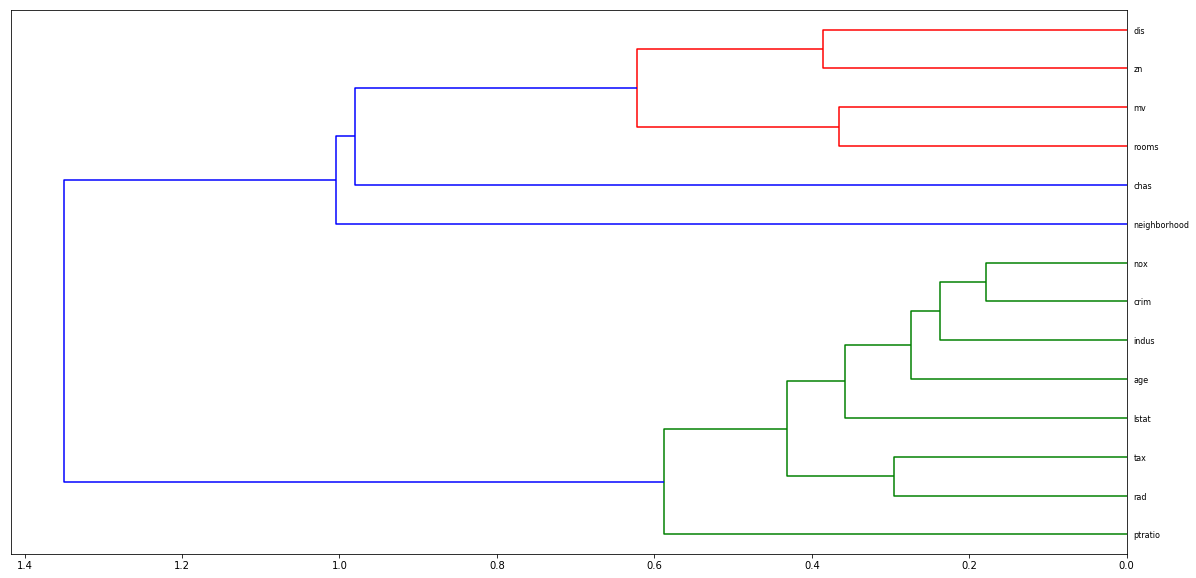

In [13]:
from scipy.cluster import hierarchy as hc
from rfpimp import feature_corr_matrix
pear_corr(boston_input)

In [14]:
# import modelling components and then use pdp to analyze highly correlated variables and potential interactions

from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,PolynomialFeatures
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedKFold,train_test_split
from sklearn.pipeline import Pipeline

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.6,random_state=5)

print(X_train.describe().T)
print(X_test.describe().T)


C:\Users\jstnj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


         count        mean         std        min       25%        50%  \
crim     303.0    3.660211    8.763046    0.01096    0.0821    0.26838   
zn       303.0   11.724422   23.232181    0.00000    0.0000    0.00000   
indus    303.0   10.948251    6.701178    1.25000    5.1300    8.56000   
chas     303.0    0.056106    0.230506    0.00000    0.0000    0.00000   
nox      303.0    0.552073    0.114915    0.38500    0.4490    0.53200   
rooms    303.0    6.292693    0.694078    3.86300    5.8865    6.20900   
age      303.0   66.792739   28.869129    2.90000   41.7000   74.80000   
dis      303.0    3.800615    2.059300    1.13700    2.1103    3.37510   
rad      303.0    9.610561    8.741703    1.00000    4.0000    5.00000   
tax      303.0  404.795380  169.279730  188.00000  277.0000  329.00000   
ptratio  303.0   18.516832    2.169463   12.60000   17.4000   19.10000   
lstat    303.0   12.641419    7.193720    2.47000    6.8800   10.97000   

                75%       max  
crim 

In [15]:
# define cv for randomized search cv

from sklearn.metrics import make_scorer

def rmsle_cv(y_true, y_pred) : 
    assert len(y_true) == len(y_pred)
    if not (y_true >= 0).all() and not (y_pred >= 0).all():
        raise ValueError("Mean Squared Logarithmic Error cannot be used when "
                         "targets contain negative values.")
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_true))**2))

rmsle_cv = make_scorer(rmsle_cv,greater_is_better=False)

rkfold = RepeatedKFold(n_splits=5,n_repeats=5)

rf = RandomForestRegressor()

rf_param = {'max_depth':[3,5,7],
           'min_samples_split':range(2,7,1),
           'max_features':[0.3,0.4,0.5,0.6],
           'n_estimators':range(50,100,10)}

rs = RandomizedSearchCV(rf,param_distributions= rf_param,scoring=rmsle_cv,cv=rkfold,n_iter=50)
rs.fit(X_train,y_train)
print(rs.best_score_)
print(rs.best_estimator_)
print(rs.score(X_test,y_test))

-0.04312879867288372
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
-0.04142344804358765


In [17]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.5,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=True)
rf.fit(X_train,y_train)
rf.oob_score_

from pdpbox import pdp

def plot_pdp(feat,clusters=None,feat_name=None):
    feat_name = feat_name or feat 
    p = pdp.pdp_isolate(rf,model_features= X_train.columns.tolist(),dataset=X_train,feature = feat) 
    return pdp.pdp_plot(p,feat_name,plot_lines=True, 
                        cluster=clusters, n_cluster_centers=clusters,plot_pts_dist=True)


(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2423447f518>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2423446fbe0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2423436db00>}})

<Figure size 432x288 with 0 Axes>

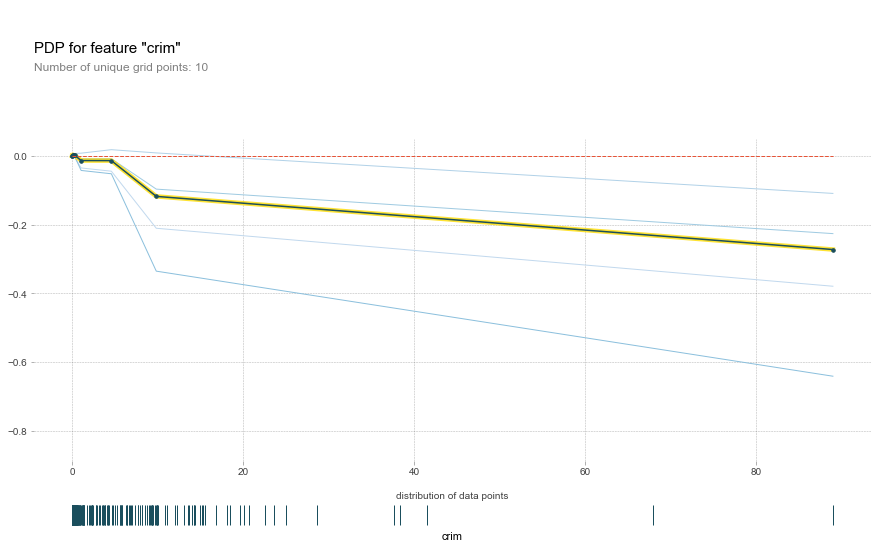

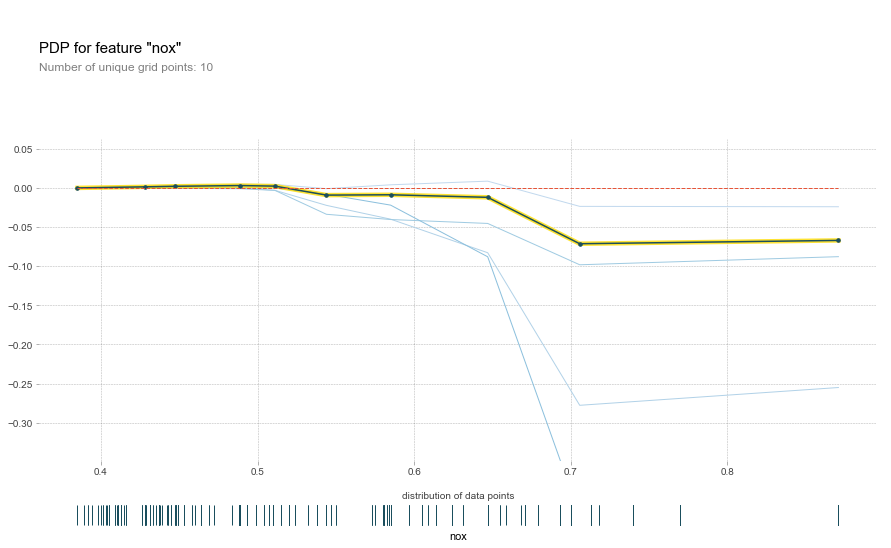

In [18]:
# plot crime and nox

plt.figure(1)
plot_pdp('crim',clusters=4)
plt.figure(2)
plot_pdp('nox',clusters=4)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x242342e2b00>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2423449cf98>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2423410d278>}})

<Figure size 432x288 with 0 Axes>

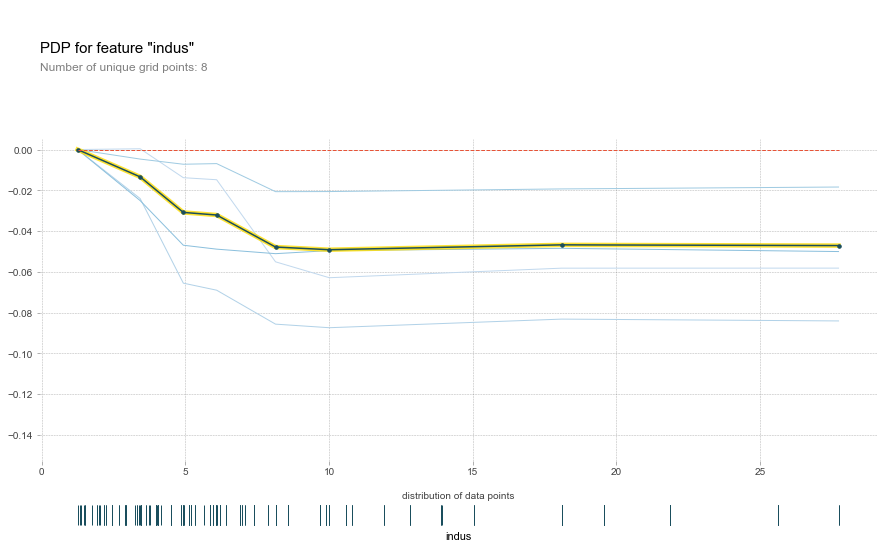

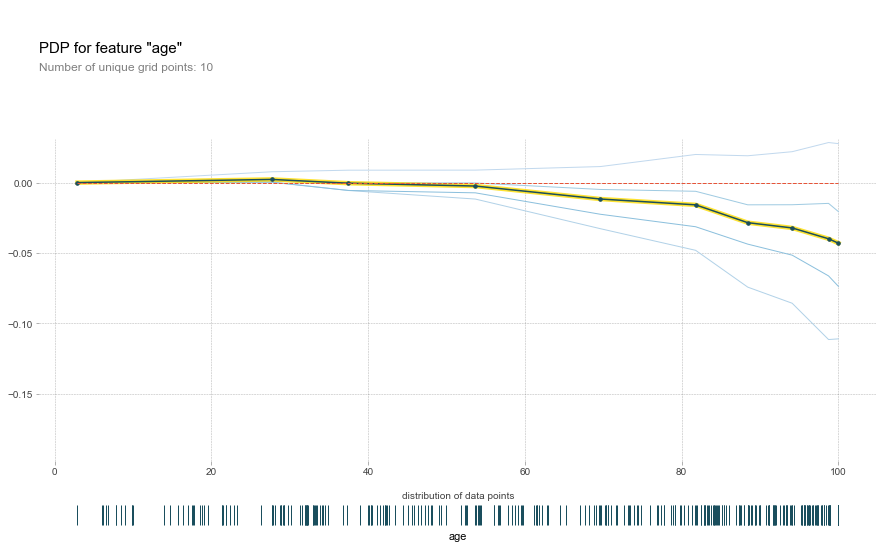

In [19]:
# plot industrial (%) and age
plt.figure(1)
plot_pdp('indus',4)
plt.figure(2)
plot_pdp('age',4)

In [20]:
# run elastic net first

elnet = ElasticNet()

params = {'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

elnet_pipe = Pipeline([('std_scaler',StandardScaler()),
              ('elnet',elnet)])

rs2 = RandomizedSearchCV(elnet_pipe,param_distributions=params,cv=rkfold,scoring=rmsle_cv,n_iter=50)

rs2.fit(X_train,y_train)
print(rs2.best_score_)
print(rs2.best_estimator_)
print(rs2.score(X_test,y_test))



-0.05491227986663385
Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elnet', ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.001, warm_start=False))])
-0.0567397923163129


In [21]:
# run with minmax scaler

elnet = ElasticNet()

params = {'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

elnet_pipe = Pipeline([('min_scaler',MinMaxScaler()),
              ('elnet',elnet)])

rs3 = RandomizedSearchCV(elnet_pipe,param_distributions=params,cv=rkfold,scoring=rmsle_cv,n_iter=50)

rs3.fit(X_train,y_train)
print(rs3.best_score_)
print(rs3.best_estimator_)
print(rs3.score(X_test,y_test))

-0.07904121706787097
Pipeline(memory=None,
     steps=[('min_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.001, warm_start=False))])
-0.07831950918236202


In [22]:
# run with max abs scaler

elnet = ElasticNet()

params = {'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

elnet_pipe = Pipeline([('max_scaler',MaxAbsScaler()),
              ('elnet',elnet)])

rs4 = RandomizedSearchCV(elnet_pipe,param_distributions=params,cv=rkfold,scoring=rmsle_cv,n_iter=50)

rs4.fit(X_train,y_train)
print(rs4.best_score_)
print(rs4.best_estimator_)
print(rs4.score(X_test,y_test))

-0.07862624375414314
Pipeline(memory=None,
     steps=[('max_scaler', MaxAbsScaler(copy=True)), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.1, warm_start=False))])
-0.07891095390326573


In [23]:
# lasso with standard scaler

lasso = Lasso()

params = {'lasso__alpha': np.arange(0.1,1,0.1)}

las_pipe =  Pipeline([('std_scaler',StandardScaler()),
            ('lasso',lasso)])

rs5 = RandomizedSearchCV(las_pipe,param_distributions=params,cv=rkfold,scoring=rmsle_cv,n_iter=9)

rs5.fit(X_train,y_train)
print(rs5.best_score_)
print(rs5.best_estimator_)
print(rs5.score(X_test,y_test))

-0.0642431572764989
Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
-0.06165037524818474


In [24]:
# lasso with minmax scaler

lasso = Lasso()

params = {'lasso__alpha': np.arange(0.1,1,0.1)}

las_pipe =  Pipeline([('min_scaler',MinMaxScaler()),
            ('lasso',lasso)])

rs5 = RandomizedSearchCV(las_pipe,param_distributions=params,cv=rkfold,scoring=rmsle_cv,n_iter=9)

rs5.fit(X_train,y_train)
print(rs5.best_score_)
print(rs5.best_estimator_)
print(rs5.score(X_test,y_test))

-0.10651627824977271
Pipeline(memory=None,
     steps=[('min_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('lasso', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
-0.1021571606118396


In [25]:
# lasso with maxabs

lasso = Lasso()

params = {'lasso__alpha': np.arange(0.1,1,0.1)}

las_pipe =  Pipeline([('max_scaler',MaxAbsScaler()),
            ('lasso',lasso)])

rs5 = RandomizedSearchCV(las_pipe,param_distributions=params,cv=rkfold,scoring=rmsle_cv,n_iter=9)

rs5.fit(X_train,y_train)
print(rs5.best_score_)
print(rs5.best_estimator_)
print(rs5.score(X_test,y_test))

-0.10651431476656813
Pipeline(memory=None,
     steps=[('max_scaler', MaxAbsScaler(copy=True)), ('lasso', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])
-0.1021571606118396


In [43]:
# feature selection with f_regression - does better with only 11 variables

from sklearn.feature_selection import SelectKBest,SelectFromModel,f_regression,SelectFwe

k_best = SelectKBest(f_regression)

k_params = ({'k_best__k':range(1,12,1),
        'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})

k_pipe = Pipeline([('k_best',k_best),
         ('stand',StandardScaler()),
           ('elnet',elnet)])
           
gs = GridSearchCV(k_pipe,param_grid=k_params,cv =rkfold, scoring= rmsle_cv)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_estimator_)
print(gs.score(X_test,y_test))

-0.0532907747415612
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=11, score_func=<function f_regression at 0x0000024233AC17B8>)), ('stand', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.001, warm_start=False))])
-0.05562702341753181


In [44]:
# feature selection with mutual_info_regression - does better with only 11 variables

k_best = SelectKBest(mutual_info_regression)

k_params = ({'k_best__k':range(1,12,1),
        'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})

k_pipe = Pipeline([('k_best',k_best),
         ('stand',StandardScaler()),
           ('elnet',elnet)])
           
gs1 = GridSearchCV(k_pipe,param_grid=k_params,cv =rkfold, scoring= rmsle_cv)
gs1.fit(X_train,y_train)
print(gs1.best_score_)
print(gs1.best_estimator_)
print(gs1.score(X_test,y_test))

-0.053809037420098974
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=11,
      score_func=<function mutual_info_regression at 0x0000024233AD28C8>)), ('stand', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elnet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.001, warm_start=False))])
-0.05562702341753181


In [46]:
# do feature selection with SelectKBest

from sklearn.feature_selection import SelectKBest,SelectFromModel,f_regression,SelectFwe,mutual_info_regression

select = SelectFromModel(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.5,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
           oob_score=True))

select_params = ({'select__threshold':[0.01,0.05,.1,.15,0.2,"mean","median","2.*mean"],
         'elnet__alpha': np.arange(0.1,1,0.1),
         'elnet__l1_ratio':np.arange(0.1,1,0.1),
         'elnet__tol':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})

k_pipe = Pipeline([('select',select),
         ('stand',StandardScaler()),
           ('elnet',elnet)])
           
gs2 = GridSearchCV(k_pipe,param_grid=select_params,cv = rkfold, scoring= rmsle_cv)
gs2.fit(X_train,y_train)
print(gs2.best_score_)
print(gs2.best_estimator_)
print(gs2.score(X_test,y_test))

-0.05509629344889431
Pipeline(memory=None,
     steps=[('select', SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_f...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])
-0.05569261283320912


In [62]:
poly = PolynomialFeatures(interaction_only=True)
columns = ['tax','crim','rooms','dis','age','nox','indus','ptratio','zn']

X_poly = poly.fit_transform(X[columns],y)
X_poly.shape


(506, 46)

In [59]:
X_poly = pd.DataFrame(X_poly,index=y.index)

# save info on which features contribute to each term in X_poly
powers = pd.DataFrame(poly.powers_,columns=X[columns].columns)

s = np.where(powers>0, pd.Series(X[columns].columns)+', ', '')
poly_terms = pd.Series([''.join(x).strip() for x in s])

In [65]:
df_poly = pd.DataFrame(X_poly,columns = poly_terms)

In [68]:
df_poly.head(100)

,,"tax,","crim,","rooms,","dis,","age,","nox,","indus,","ptratio,","zn,",...,"age, nox,","age, indus,","age, ptratio,","age, zn,","nox, indus,","nox, ptratio,","nox, zn,","indus, ptratio,","indus, zn,","ptratio, zn,"
0,1.0,296.0,0.00632,6.575,4.0900,65.2,0.538,2.31,15.3,18.0,...,35.0776,150.612,997.56,1173.60,1.24278,8.2314,9.684,35.343,41.580,275.4
1,1.0,242.0,0.02731,6.421,4.9671,78.9,0.469,7.07,17.8,0.0,...,37.0041,557.823,1404.42,0.00,3.31583,8.3482,0.000,125.846,0.000,0.0
2,1.0,242.0,0.02729,7.185,4.9671,61.1,0.469,7.07,17.8,0.0,...,28.6559,431.977,1087.58,0.00,3.31583,8.3482,0.000,125.846,0.000,0.0
3,1.0,222.0,0.03237,6.998,6.0622,45.8,0.458,2.18,18.7,0.0,...,20.9764,99.844,856.46,0.00,0.99844,8.5646,0.000,40.766,0.000,0.0
4,1.0,222.0,0.06905,7.147,6.0622,54.2,0.458,2.18,18.7,0.0,...,24.8236,118.156,1013.54,0.00,0.99844,8.5646,0.000,40.766,0.000,0.0
5,1.0,222.0,0.02985,6.430,6.0622,58.7,0.458,2.18,18.7,0.0,...,26.8846,127.966,1097.69,0.00,0.99844,8.5646,0.000,40.766,0.000,0.0
6,1.0,311.0,0.08829,6.012,5.5605,66.6,0.524,7.87,15.2,12.5,...,34.8984,524.142,1012.32,832.50,4.12388,7.9648,6.550,119.624,98.375,190.0
7,1.0,311.0,0.14455,6.172,5.9505,96.1,0.524,7.87,15.2,12.5,...,50.3564,756.307,1460.72,1201.25,4.12388,7.9648,6.550,119.624,98.375,190.0
8,1.0,311.0,0.21124,5.631,6.0821,100.0,0.524,7.87,15.2,12.5,...,52.4000,787.000,1520.00,1250.00,4.12388,7.9648,6.550,119.624,98.375,190.0
9,1.0,311.0,0.17004,6.004,6.5921,85.9,0.524,7.87,15.2,12.5,...,45.0116,676.033,1305.68,1073.75,4.12388,7.9648,6.550,119.624,98.375,190.0
